<a href="https://colab.research.google.com/github/kevinkevin556/Dlchemist/blob/main/nin2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Network in Network**

# **Section 1. Set up**

In [ ]:
!pip install einops

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### *Dataset and DataLoader*


How to normalize CIFAR-10: [link](https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py).

In [ ]:
from torch.utils.data import Dataset, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage, Normalize

cifar10 = CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
data_means = (cifar10.data / 255.0).mean(axis=(0,1,2))
data_std = (cifar10.data / 255.0).std(axis=(0,1,2))
print("Data mean", data_means)
print("Data std", data_std)

In [ ]:
from torch.utils.data import Dataset, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage
from einops import rearrange


class CIFAR10Dataset(Dataset):
  def __init__(self, root="./data", mean=None, W=None,train=False, download=True, index=None):    
    cifar10 = CIFAR10(root, train, download=download)
    if index is None:
      self.data, self.targets = cifar10.data, cifar10.targets
    else:
      self.data = cifar10.data[index]
      self.targets = [cifar10.targets[i] for i in index]

    self.mean = self.data.mean(axis=0) if mean is None else mean
    self.W = self.zca_matrix((self.data-self.mean)/255.0) if W is None else W
    self.tensors = self.whiten_all_images()


  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx):
    image, label = self.tensors[idx], self.targets[idx]
    return image, label


  def zca_matrix(self, images):
    n = len(self.targets)  
    images = rearrange(images, 'N H W C -> N (H W C)')
    cov = torch.cov(Tensor(images.T))
    L, V = torch.linalg.eig(cov)
    L, V = L.real, V.real
    W = V @ torch.diag(L**(-0.5)) @ V.T
    return W


  def whiten(self, images):
    ## Whiten the image
    images = rearrange(images, 'N H W C -> N (H W C)')
    whiten_images =  Tensor(images) @ self.W 
    
    ## Tensorize the image: (dim=(c, h, w) & range=(0, 1))
    whiten_images = rearrange(whiten_images, 'N (H W C) -> N C H W', H=32, W=32)
    whiten_images = torch.clip(whiten_images, 0, 1)
    return whiten_images
  

  def whiten_all_images(self):
    n = len(self.targets)
    whiten_images = torch.empty((n, 3, 32, 32))
    batch = 100
    for i in tqdm(range(n//batch), desc="Whitening all data..."):
      images = self.data[batch*i:batch*(i+1)]
      images = (images-self.mean)/255                           # normalization
      whiten_images[batch*i:batch*(i+1)] = self.whiten(images)  # zca-whitening
    return whiten_images

[ZCA1](https://stats.stackexchange.com/questions/117427/what-is-the-difference-between-zca-whitening-and-pca-whitening)
[ZCA2](https://towardsdatascience.com/pca-whitening-vs-zca-whitening-a-numpy-2d-visual-518b32033edf#:~:text=ZCA%2Dwhitening%20is%20done%20by,possible%20from%20the%20original%20data.)

In [ ]:
# Generate indices to permute the training data and conduct train-test-split
total_size = 50000
valid_size = total_size // 10
rng = np.random.default_rng(42)
indices = rng.permutation(total_size)

train_dataset = CIFAR10Dataset(train=True, index=indices[:-valid_size])
mean = train_dataset.mean
W = train_dataset.W

valid_dataset = CIFAR10Dataset(train=True, mean=mean, W=W, index=indices[-valid_size:])
test_dataset = CIFAR10Dataset(train=False, mean=mean, W=W)


print("\nData Size:")
print("* Training set   => ", len(train_dataset), "images")
print("* Validation set => ", len(valid_dataset), "images")
print("* Testing set    => ", len(test_dataset), "images")

print("\nImage Shape (C, H, W):")
print("* Training image:", train_dataset[0][0].shape)
print("* Testing image: ", test_dataset[0][0].shape)

In [ ]:
import matplotlib.pyplot as plt

n_view = 10
pil_dstack = lambda images: ToPILImage()(torch.dstack(images))

# Sample images
raw_images = np.hstack([train_dataset.data[i] for i in range(n_view)])
demeaned_images = np.hstack([train_dataset.data[i] - mean for i in range(n_view)])
images = pil_dstack([train_dataset[i][0] for i in range(n_view)])
targets = [train_dataset[i][1] for i in range(n_view)]

fig, ax = plt.subplots(3, 1, figsize=(20, 7))
ax[0].imshow(raw_images)
ax[0].set_title("Raw Images")
ax[0].axis('off')

ax[1].imshow(demeaned_images)
ax[1].set_title("Demeaned images")
ax[1].axis('off')

ax[2].imshow(images)
ax[2].set_title("ZCA Whitened Images")
ax[2].set_xticks(ticks=np.array(range(10))*32+16)
ax[2].set_xticklabels(targets, {'fontsize':16})
plt.show()
plt.close()


image_shape = tuple(train_dataset[0][0].shape)
print("\nImage shape:", image_shape)

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

### *Network Architecture*

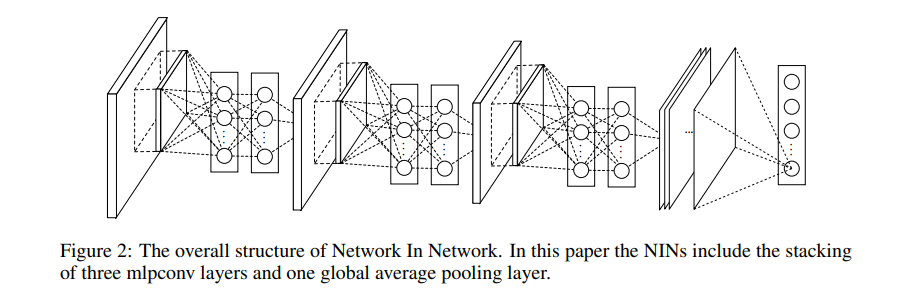

The network architecture is built based on this [prototext](https://gist.github.com/mavenlin/e56253735ef32c3c296d) from the Caffe model zoo. Note one should set `MaxPool2d(ceil_mode=True)` to get the correct dimension.


In [ ]:
from torch.nn import (
    Conv2d, ReLU, MaxPool2d, AvgPool2d, Dropout, Sequential, Flatten
)


def CCCP(in_channels, out_channels):
  return Conv2d(in_channels, out_channels, kernel_size=1)

def MlpConv(in_channels, hidden_channels, out_channels, kernel_size, stride=1, padding=0):
  return nn.Sequential(
      Conv2d(in_channels, hidden_channels[0], kernel_size, stride, padding),
      ReLU(),
      CCCP(hidden_channels[0], hidden_channels[1]),
      ReLU(),
      CCCP(hidden_channels[1], out_channels),
      ReLU()
  )

class NiN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net = Sequential(
        MlpConv(3, (192, 160), 96, kernel_size=5, padding=2),
        MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        Dropout(p=0.5),

        MlpConv(96, (192, 192), 192, kernel_size=5, padding=2),
        AvgPool2d(kernel_size=3, stride=2, ceil_mode=True),
        Dropout(p=0.5),

        MlpConv(192, (192, 192), num_classes, kernel_size=3, padding=1),
        AvgPool2d(kernel_size=8, stride=1),
        Flatten()
    )

    # Remember to initialize the weights and biases.
    # Default initialization from pytorch doesn't work well.
    self.net.apply(self.init_weights)

  def forward(self, x):
    return self.net(x)

  @staticmethod
  def init_weights(m):
    if isinstance(m, Conv2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.05)
        torch.nn.init.zeros_(m.bias)

print(NiN())

In [ ]:
# Check forward path
X = torch.randn(1, *image_shape)
print(f"{'Image shape:':25s} {list(X.shape)}")
for layer in NiN().net:
    X=layer(X)
    print(f"{layer.__class__.__name__+' output shape:':25s} {list(X.shape)}")

### *HyperModule*

In [ ]:
import sklearn.metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class HyperModule():
    def __init__(self, model, criterion, optimizer, scheduler=None, load_path=None):
        if load_path is None:
            self.model, self.criterion, self.optimizer = model, criterion, optimizer
            self.scheduler = scheduler
            self.epoch_trained = 0
            self.train_loss = []
            self.valid_acc = []
            self.test_acc = None
        else:
            self.load(load_path)


    def train(self, train_dataloader, valid_dataloader, save_path=None, num_epochs=1):
        device = torch.device('cuda')
        self.model.to(device)
        best_acc = 0 if len(self.valid_acc)==0 else max(self.valid_acc) 
        start_epoch = self.epoch_trained

        for epoch in range(num_epochs):
            self.model.train()
            self.batch_loss, self.batch_acc = [], []
            self.epoch_trained += 1

            train_progress = tqdm(train_dataloader, position=0, leave=True)  ## Train
            for images, targets in train_progress:
                images, targets = images.to(device), targets.to(device)
                self.update_(images, targets)
                self.update_prog_(train_progress, start_epoch+num_epochs)
           
            self.update_schd_()  ## Update scheduler

            self.batch_acc = self.validate(valid_dataloader) ## Validate
            self.update_hist_()
            print(f"Train Loss: {np.mean(self.batch_loss):.3f}, Valid Acc:{np.mean(self.batch_acc):.3f}")
            
            if np.mean(self.batch_acc) > best_acc:  ## Save the best model (if any)
                best_acc = np.mean(self.batch_acc)
                self.save(save_path)

        self.batch_loss, self.batch_acc = [], []
        self.test_acc = None
        

    def validate(self, dataloader):
        device = torch.device('cuda')
        self.model.eval()
        batch_acc = []
        with torch.no_grad():
            for images, targets in dataloader:
                images, targets = images.to(device), targets.to(device)
                preds = self.model(images)
                pred_labels = torch.argmax(preds, dim=1)
                batch_acc.append((pred_labels == targets).type(torch.float32).mean().item())
        return batch_acc


    def test(self, dataloader, load_path=None, confusion_matrix=True, class_names=None):
        device = torch.device('cuda')
        np_pred_labels, np_targets = [], [] 
        if load_path is not None:
            self.load(load_path)
        self.model.to(device)
        self.model.eval()

        # Obtain predictions and ground truths
        with torch.no_grad():
            for images, targets in dataloader:
                images, targets = images.to(device), targets.to(device)
                pred_labels, targets = self.get_prediction_(images, targets)
                np_pred_labels.append(pred_labels)
                np_targets.append(targets)

        np_pred_labels = np.concatenate(np_pred_labels)
        np_targets = np.concatenate(np_targets)

        if confusion_matrix:
            conf_mat = sklearn.metrics.confusion_matrix(np_targets, np_pred_labels)
            conf_df = self.generate_confusion_df_(conf_mat, class_names)
            self.plot_confusion_matrix_(conf_df)
            self.print_class_acc_(conf_df)
        
        ## print total accuracy
        self.test_acc = np.mean(np_targets == np_pred_labels)
        print("\nTotal Acc:", np.mean(np_targets == np_pred_labels))

                
    def load(self, path):
        state_dict = torch.load(path)
        self.model.load_state_dict(state_dict["model"])
        self.optimizer.load_state_dict(state_dict["optimizer"])
        self.scheduler.load_state_dict(state_dict["scheduler"])
        self.test_acc = state_dict["test_acc"]
        self.epoch_trained = state_dict["epoch_trained"]
        self.train_loss = state_dict["train_loss"]
        self.valid_acc = state_dict["valid_acc"]
        print("State dict sucessfully loaded.")


    def save(self, path):
        state_dict = {}
        state_dict["model"] = self.model.state_dict()
        state_dict["optimizer"] = self.optimizer.state_dict()
        state_dict["scheduler"] = self.scheduler.state_dict()
        state_dict["epoch_trained"] = self.epoch_trained
        state_dict["train_loss"] = self.train_loss
        state_dict["valid_acc"] = self.valid_acc
        state_dict["test_acc"] = self.test_acc
        torch.save(state_dict, path)
        print("State dict saved.")
    

    def get_state_dict(self):
        state_dict = {}
        state_dict["model"] = self.model.state_dict()
        state_dict["optimizer"] = self.optimizer.state_dict()
        state_dict["scheduler"] = self.scheduler.state_dict()
        state_dict["epoch_trained"] = self.epoch_trained
        state_dict["train_loss"] = self.train_loss
        state_dict["valid_acc"] = self.valid_acc
        state_dict["test_acc"] = self.test_acc
        return state_dict

    #--------------------------------------------------------------------------#

    ### Auxilary functions in test()
     
    def get_prediction_(self, images, targets):
        preds = self.model(images)
        pred_labels = torch.argmax(preds, dim=1)
        pred_labels = pred_labels.view(-1).detach().cpu().numpy()
        targets = targets.view(-1).detach().cpu().numpy()
        return pred_labels, targets

    def generate_confusion_df_(self, conf_mat, class_names):
        if class_names is not None:
            conf_df = pd.DataFrame(conf_mat, class_names, class_names)
        else:
            conf_df = pd.DataFrame(conf_mat)
        return conf_df
        
    def plot_confusion_matrix_(self, conf_df):
        plt.figure(figsize = (12,8))
        sns.heatmap(conf_df, annot=True, fmt="d", cmap='Blues')
        plt.xlabel("prediction")
        plt.ylabel("label (ground truth)")
        plt.show()

    def print_class_acc_(self, conf_df):
        for i in range(len(conf_df)):
            total = np.sum(conf_df.iloc[i, :])
            correct = conf_df.iloc[i, i]
            print(f"Acc of {conf_df.columns[i]}: {correct/total:.4f}")

    
    ### Auxilary functions in train()
    
    def update_(self, images, targets):
        preds = self.model(images)
        loss = self.criterion(preds, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.batch_loss.append(loss.detach().item())

    def update_prog_(self, progress, num_epochs):
        loss = self.batch_loss[-1]
        epoch = self.epoch_trained
        progress.set_description(f'Epoch [{epoch}/{num_epochs}]')
        progress.set_postfix({'loss': loss})

    def update_schd_(self):
        if self.scheduler is not None:
            self.scheduler.step()

    def update_hist_(self):
        # print("Train loss updated:", np.mean(self.batch_loss))
        self.train_loss.append(np.mean(self.batch_loss))
        # print("Valid acc updated:", np.mean(self.batch_acc))
        self.valid_acc.append(np.mean(self.batch_acc))

# **Section 2. Start Training**

### *Optimization Configuration and First Training Stage*

In [ ]:
BASE_LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
STEP_SIZE = 1e5
GAMMA = 0.1
NUM_EPOCHS = 230
PATH = "/content/gdrive/MyDrive/Colab Checkpoints/state_dict.ckpt"

In [ ]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

nin = NiN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nin.parameters(), BASE_LR, MOMENTUM, 0, WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, STEP_SIZE, GAMMA)

hm = HyperModule(
    model = nin,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler
)

hm.train(train_dataloader, valid_dataloader, PATH, NUM_EPOCHS)

In [ ]:
hm.test(test_dataloader, load_path=PATH, class_names=class_names)

Reference:
* [Network In Network](https://arxiv.org/pdf/1312.4400.pdf)
* [Dive into Deep Learning - Section 8.3](http://d2l.ai/chapter_convolutional-modern/nin.html)
* [Blog Post from 星期五。見面](https://meetonfriday.com/posts/a151bfa2/)
* [Blog Post from Math.py](https://allen108108.github.io/blog/2019/10/07/%5B%E8%AB%96%E6%96%87%5D%20Network%20In%20Network/)